# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.326689,False,0.448556
1,-0.906599,True,2.325172
2,0.378685,False,-1.157150
3,-0.299435,False,0.630886
4,1.042586,True,2.949594
...,...,...,...
995,0.770774,True,5.430327
996,-0.586816,True,5.585402
997,0.722458,False,1.299977
998,-0.395364,True,4.492349


<AxesSubplot:xlabel='v0'>

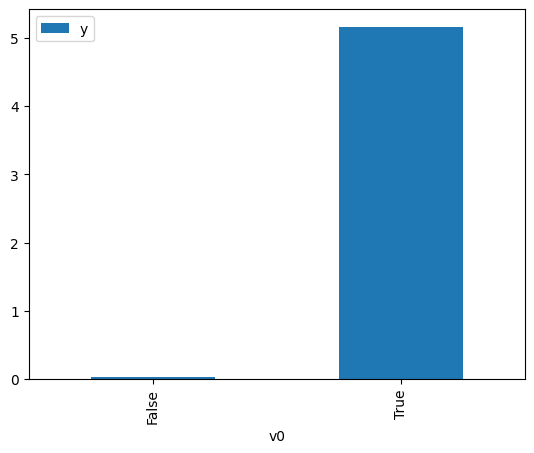

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

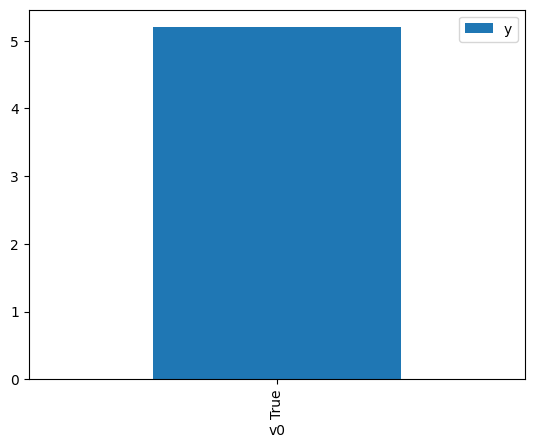

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.114414,False,0.806617,0.521814,1.916392
1,-0.437425,False,-1.844901,0.527280,1.896524
2,0.908197,False,1.566832,0.504479,1.982241
3,0.180203,False,-1.473251,0.516823,1.934897
4,-0.919758,False,-1.201705,0.535431,1.867655
...,...,...,...,...,...
995,-0.924271,False,-0.188714,0.535507,1.867390
996,1.820202,False,1.088118,0.489009,2.044950
997,0.039937,False,-1.274895,0.519200,1.926041
998,0.035028,False,0.371365,0.519283,1.925732


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,2.356333,True,6.847476,0.520077,1.922793
1,1.841864,True,6.748936,0.511358,1.955578
2,-0.758494,True,4.397192,0.467292,2.139988
3,-0.741826,True,5.669855,0.467574,2.138699
4,-2.428560,True,2.266709,0.439216,2.276786
...,...,...,...,...,...
995,-1.083720,True,5.126413,0.461803,2.165426
996,-0.411489,True,3.131912,0.473158,2.113458
997,-2.217379,True,2.438822,0.442748,2.258620
998,-1.247205,True,4.836007,0.459047,2.178427


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.934
Model:                            OLS   Adj. R-squared (uncentered):              0.934
Method:                 Least Squares   F-statistic:                              7076.
Date:                Wed, 14 Sep 2022   Prob (F-statistic):                        0.00
Time:                        18:55:14   Log-Likelihood:                         -1395.1
No. Observations:                1000   AIC:                                      2794.
Df Residuals:                     998   BIC:                                      2804.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7558      0.031     24.243      0.000       0.695       0.817
x2             5.0264      0.045    111.891      0.000       4.938       5.115
==============================================================================
Omnibus:                        0.256   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.880   Jarque-Bera (JB):                0.322
Skew:                           0.031   Prob(JB):                        0.851
Kurtosis:                       2.938   Cond. No.                         1.48
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""